In [1]:
# AMP decoder for signal recovery in compressed sensing.
# CS model: y = Ax + noise
# Goal: recover x given y and A
#
# Compare the mean squared error (MSE) performance of the AMP decoder
# with either the MMSE denoiser or the soft-thresholding denoiser
# in each AMP iteration. 
#
# This notebooks considers two different signal distributions.
# The entries of the signal vector are drawn i.i.d. according to either
# 1) A 3-point distribution. Equal to 0 with probability (1-eps) and 
#    equal to either +1 or -1 with probability eps/2 each.
# 2) Bernoulli-Gaussian distribution. Equal to 0 with probability (1-eps)
#    and drawn from standard Gaussian with probability eps.
# 
# For each signal distribution:
# 1) We run an instance of AMP decoding for a choice of system parameters.
#    We see that the MMSE denoiser achieves lower MSE compared to the 
#    soft-thresholding denoiser.
# 2) We plot the undersampling ratio vs. sparsity ratio MSE phase diagram.
#    We see that the MMSE achieves a larger "successful recovery" region
#    compared to the soft-thresholding denoiser.
#
# Copyright (c) 2021 Kuan Hsieh

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from matplotlib.colors import LogNorm
from amp4cs import initialise_CS, opt_tuning_param, amp, amp_3pt, amp_bg

# Three-point distribution

## Single decoding instance

In [2]:
N     = 1000  # dimension of signal
M     = 500  # num of measurements
K     = 30   # num of non-zero coefficients
sigma = 0.1  # Noise standard deviation

eps      = K/N
alpha    = opt_tuning_param(eps) # Find optimal alpha
iter_max = 20 # Max num of iterations

y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=0)

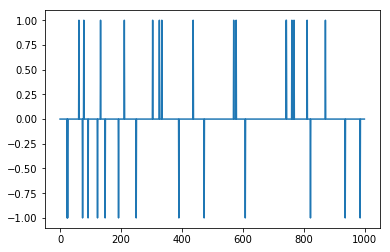

In [3]:
# Plot N-dim signal vector to recover
# Entries generated from 3-point distribution with probability (1-eps) at 0
plt.plot(x_init)

In [4]:
# Run AMP decoder with both soft-thresholding and MMSE denoiser

x_amp   = np.zeros_like(x_init) # Initial signal estimate
x_amp_b = np.zeros_like(x_init)
z_amp   = y                     # Initial residual
z_amp_b = y                           

mse_amp = np.zeros(iter_max)    # Store empirical MSE across iterations
mse_amp_b = np.zeros(iter_max)

for t in range(iter_max):
    (x_amp, z_amp)     = amp(y, A, x_amp, z_amp, alpha)
    (x_amp_b, z_amp_b) = amp_3pt(y, A, x_amp_b, z_amp_b, eps)
    mse_amp[t]         = np.mean((x_amp-x_init)**2)
    mse_amp_b[t]       = np.mean((x_amp_b-x_init)**2)

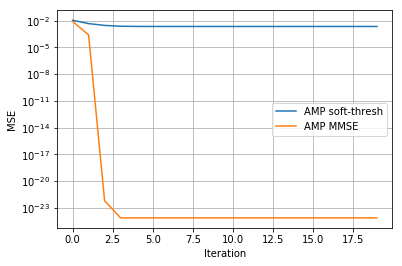

In [5]:
plt.plot(mse_amp,   label='AMP soft-thresh')
plt.plot(mse_amp_b, label='AMP MMSE')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'AMP w/ MMSE denoiser')

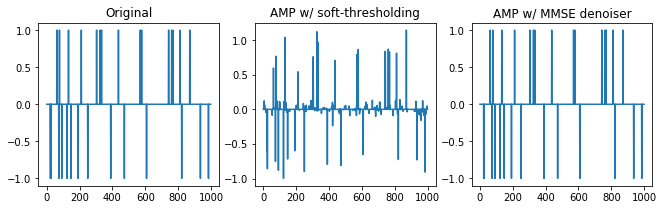

In [6]:
# Plot recovered signal from compressed sensing measurements

plt.figure(figsize=(11,3))
plt.subplot(131)
plt.plot(x_init)
plt.title('Original')
plt.subplot(132)
plt.plot(x_amp)
plt.title('AMP w/ soft-thresholding')
plt.subplot(133)
plt.plot(x_amp_b)
plt.title('AMP w/ MMSE denoiser')

## Plot undersampling-sparsity MSE phase diagram

In [7]:
start = time.perf_counter()

N         = 500   # Dimension of signal
iter_max  = 50    # Iteration limit
numOfRuns = 10    # Number of runs to calculate the median
sigma     = 0.025 # Noise standard deviation

n     = 20 # Number of equispaces samples on each axis of the graph
rho   = np.linspace(1/n, 1, n) # sparsity ratios
delta = np.linspace(1/n, 1, n) # undersampling ratios

errStore   = np.ones(numOfRuns)*np.nan # Store error in estimation for each run
errArray   = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha
errStore_b = np.ones(numOfRuns)*np.nan # Store error in estimation for each run
errArray_b = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha

for i in range(n):
    if (np.around(delta[i]*100) % 20) == 0:
        print(str(np.around(delta[i]*100))+"%")    
    for j in range(n):
        eps   = delta[i]*rho[j]
        alpha = opt_tuning_param(eps)
        for run in range(numOfRuns):
            M = np.around(N * delta[i]).astype(int)
            K = np.around(M * rho[j]).astype(int)
            
            y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=0)

            # AMP decoding
            x_amp   = np.zeros_like(x_init) # Initial signal estimate
            x_amp_b = np.zeros_like(x_init)
            z_amp   = y                     # Initial residual
            z_amp_b = y
            for t in range(iter_max):
                (x_amp, z_amp)     = amp(y, A, x_amp, z_amp, alpha)
                (x_amp_b, z_amp_b) = amp_3pt(y, A, x_amp_b, z_amp_b, eps)
                
            errStore[run]   = np.mean((x_amp-x_init)**2) 
            errStore_b[run] = np.mean((x_amp_b-x_init)**2)
        errArray[j,i]   = np.median(errStore)   # Note swap of i & j since rhos are rows
        errArray_b[j,i] = np.median(errStore_b)

print("time elapsed (s):", time.perf_counter()-start)   

20.0%
40.0%
60.0%
80.0%
100.0%
time elapsed (s): 100.014687737


Text(0, 0.5, '$\\rho = K/M$')

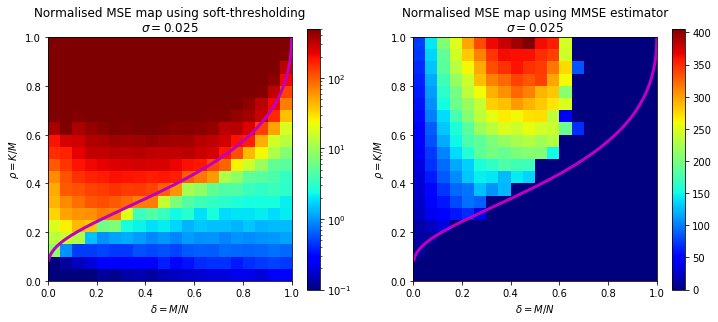

In [8]:
# This is the Donoho-Tanner phase transition curve
alpha2 = np.linspace(0,3,300)
delta2 = 2*norm.pdf(alpha2)/(alpha2+2*(norm.pdf(alpha2)-alpha2*norm.cdf(-alpha2)))
rho2   = 1 - alpha2*norm.cdf(-alpha2)/norm.pdf(alpha2)

# Plot the MSE phase diagrams
# NOTICE THE DIFFERENCE IN THE MSE SCALING IN THE COLORBAR

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(delta2, rho2,'m', linewidth=3.0)
plt.imshow(errArray/sigma**2, norm=LogNorm(vmin=1e-1, vmax=5*1e2), cmap='jet',
           interpolation='none', origin='lower', extent=(0,1,0,1))
# plt.imshow(errArray, interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map using soft-thresholding' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')

plt.subplot(122)
plt.plot(delta2, rho2, 'm',linewidth=3.0)
# plt.imshow(errArray_b/sigma**2, norm=LogNorm(vmin=1e-1, vmax=1e1), cmap='jet',
#            interpolation='none', origin='lower', extent=(0,1,0,1))
plt.imshow(errArray_b/sigma**2, cmap='jet', interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map using MMSE estimator' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')

# Bernoulli-Gaussian distribution

## Single decoding instance

In [9]:
N     = 1000  # dimension of signal
M     = 500  # num of measurements
K     = 30   # num of non-zero coefficients
sigma = 0.1  # Noise standard deviation

eps      = K/N
alpha    = opt_tuning_param(eps) # Find optimal alpha
iter_max = 20 # Max num of iterations

y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=1)

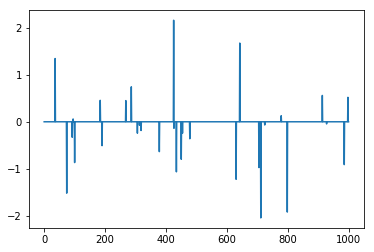

In [10]:
# Plot N-dim signal vector to recover
# K non-entries generated i.i.d. from standard Gaussian
plt.plot(x_init)

In [11]:
# Run AMP decoder with both soft-thresholding and MMSE denoiser

x_amp   = np.zeros_like(x_init) # Initial signal estimate
x_amp_b = np.zeros_like(x_init)
z_amp   = y                     # Initial residual
z_amp_b = y                           

mse_amp = np.zeros(iter_max)    # Store empirical MSE across iterations
mse_amp_b = np.zeros(iter_max)

for t in range(iter_max):
    (x_amp, z_amp)     = amp(y, A, x_amp, z_amp, alpha)
    (x_amp_b, z_amp_b) = amp_bg(y, A, x_amp_b, z_amp_b, eps)
    mse_amp[t]         = np.mean((x_amp-x_init)**2)
    mse_amp_b[t]       = np.mean((x_amp_b-x_init)**2)

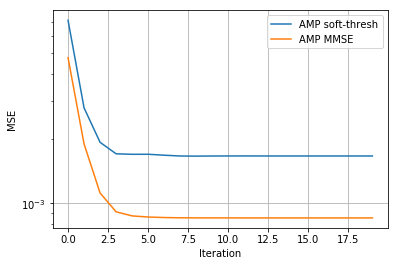

In [12]:
plt.plot(mse_amp,   label='AMP soft-thresh')
plt.plot(mse_amp_b, label='AMP MMSE')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'AMP w/ MMSE denoiser')

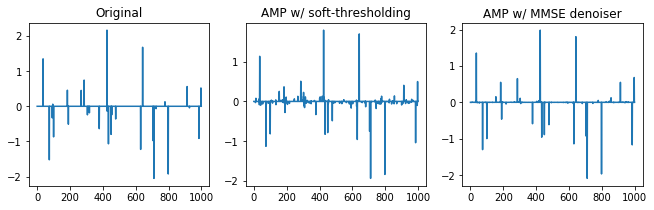

In [13]:
# Plot recovered signal from compressed sensing measurements
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.plot(x_init)
plt.title('Original')
plt.subplot(132)
plt.plot(x_amp)
plt.title('AMP w/ soft-thresholding')
plt.subplot(133)
plt.plot(x_amp_b)
plt.title('AMP w/ MMSE denoiser')

## Plot undersampling-sparsity MSE phase diagram

In [14]:
start = time.perf_counter()

N         = 500   # Dimension of signal
iter_max  = 50    # Iteration limit
numOfRuns = 10    # Number of runs to calculate the median
sigma     = 0.025 # Noise standard deviation

n     = 20 # Number of equispaces samples on each axis of the graph
rho   = np.linspace(1/n, 1, n) # sparsity ratios
delta = np.linspace(1/n, 1, n) # undersampling ratios

errStore   = np.ones(numOfRuns)*np.nan # Store error in estimation for each run
errArray   = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha
errStore_b = np.ones(numOfRuns)*np.nan # Store error in estimation for each run
errArray_b = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha

for i in range(n):
    if (np.around(delta[i]*100) % 20) == 0:
        print(str(np.around(delta[i]*100))+"%")    
    for j in range(n):
        eps   = delta[i]*rho[j]
        alpha = opt_tuning_param(eps)
        for run in range(numOfRuns):
            M = np.around(N * delta[i]).astype(int)
            K = np.around(M * rho[j]).astype(int)
            
            y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=1)

            # AMP decoding
            x_amp   = np.zeros_like(x_init) # Initial signal estimate
            x_amp_b = np.zeros_like(x_init)
            z_amp   = y                     # Initial residual
            z_amp_b = y
            for t in range(iter_max):
                (x_amp, z_amp)     = amp(y, A, x_amp, z_amp, alpha)
                (x_amp_b, z_amp_b) = amp_bg(y, A, x_amp_b, z_amp_b, eps)
                
            errStore[run]   = np.mean((x_amp-x_init)**2) 
            errStore_b[run] = np.mean((x_amp_b-x_init)**2)
        errArray[j,i]   = np.median(errStore)   # Note swap of i & j since rhos are rows
        errArray_b[j,i] = np.median(errStore_b)

print("time elapsed (s):", time.perf_counter()-start)   

20.0%
40.0%
60.0%
80.0%
100.0%
time elapsed (s): 52.84411002999998


Text(0, 0.5, '$\\rho = K/M$')

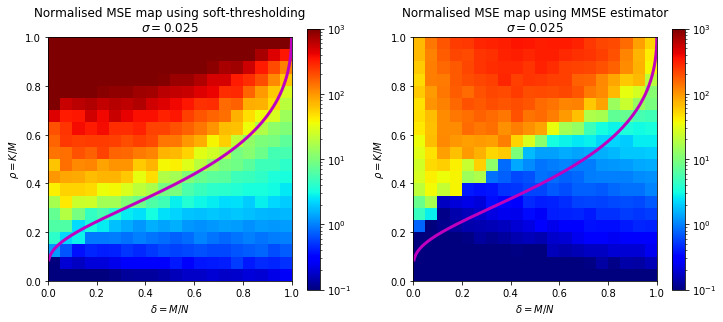

In [15]:
# This is the Donoho-Tanner phase transition curve
alpha2 = np.linspace(0,3,300)
delta2 = 2*norm.pdf(alpha2)/(alpha2+2*(norm.pdf(alpha2)-alpha2*norm.cdf(-alpha2)))
rho2   = 1 - alpha2*norm.cdf(-alpha2)/norm.pdf(alpha2)

# Plot the MSE phase diagrams
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(delta2, rho2,'m', linewidth=3.0)
plt.imshow(errArray/sigma**2, norm=LogNorm(vmin=1e-1, vmax=1e3), cmap='jet',
           interpolation='none', origin='lower', extent=(0,1,0,1))
# plt.imshow(errArray, interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map using soft-thresholding' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')

plt.subplot(122)
plt.plot(delta2, rho2, 'm',linewidth=3.0)
plt.imshow(errArray_b/sigma**2, norm=LogNorm(vmin=1e-1, vmax=1e3), cmap='jet',
           interpolation='none', origin='lower', extent=(0,1,0,1))
# plt.imshow(errArray_b/sigma**2, cmap='jet', interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map using MMSE estimator' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')